In [46]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from collections import Counter
from matplotlib.image import imread
import cv2
import random
from ultralytics import YOLO



/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.2


In [4]:
# Read the images
# create bounding box
# Visualize the distribution
# Data augmentation
# Image preprocessing
# Yolo training
# Evaluation metrics
# External app

In [48]:
TRAIN_PATH='LISA road signs.v1i.yolov11/train/images'
TRAIN_LABELS = 'LISA road signs.v1i.yolov11/train/labels'
TEST_PATH = 'LISA road signs.v1i.yolov11/test/images'
OUTPUT_DIR=''

CLASSES = ''

In [6]:
def get_labels():
    filenames = [f for f in os.listdir(TRAIN_PATH)]
    raw_labels = [label.split('_')[0] for label in filenames]
    class_labels = set(raw_labels)
    label_dict = Counter(raw_labels)
    sorted_label_dict = dict(sorted(label_dict.items(), key=lambda item: item[1]))
    return class_labels, sorted_label_dict
    
   
# Get all class names from filename. Example: keepRight_1333395677-avi_image8_png.rf.b1c606b890f97941185c51268eb110e2
class_labels, label_dict = get_labels()
print(class_labels)
print(label_dict)


{'truckSpeedLimit', 'rightLaneEnds', 'doNotPass', 'noLeftTurn', 'noUTurn', 'exitSpeedAdvisory', 'turnRight', 'yield', 'speedLimit35', 'curve', 'thruMergeRight', 'speedLimit30', 'leftTurn', 'keepRight', 'rampSpeedAdvisory', 'zoneAhead45', 'speedLimit', 'turnLeft', 'curveLeft', 'schoolSpeedLimit', 'doNotEnter', 'pedestrian', 'signalAhead', 'speedLimit45', 'yieldAhead', 'rampSpeedAdvisory20', 'speedLimitWhenFlashing', 'speedLimit65', 'stop', 'school', 'noRightTurn', 'thruMergeLeft', 'stopAhead', 'speedLimit25', 'rightLaneMustTurn', 'pedestrianCrossing', 'addedLane', 'laneEnds', 'zoneAhead25', 'schoolSpeedLimit25', 'roundabout', 'truckSpeedLimit55', 'dip', 'rampSpeedAdvisory35', 'merge', 'slow', 'curveRight'}
{'turnLeft': 6, 'doNotEnter': 8, 'curve': 8, 'rampSpeedAdvisory35': 8, 'speedLimitWhenFlashing': 8, 'thruMergeRight': 10, 'rampSpeedAdvisory20': 10, 'zoneAhead45': 14, 'doNotPass': 14, 'rightLaneEnds': 22, 'truckSpeedLimit55': 26, 'curveLeft': 28, 'truckSpeedLimit': 28, 'schoolSpeedLi

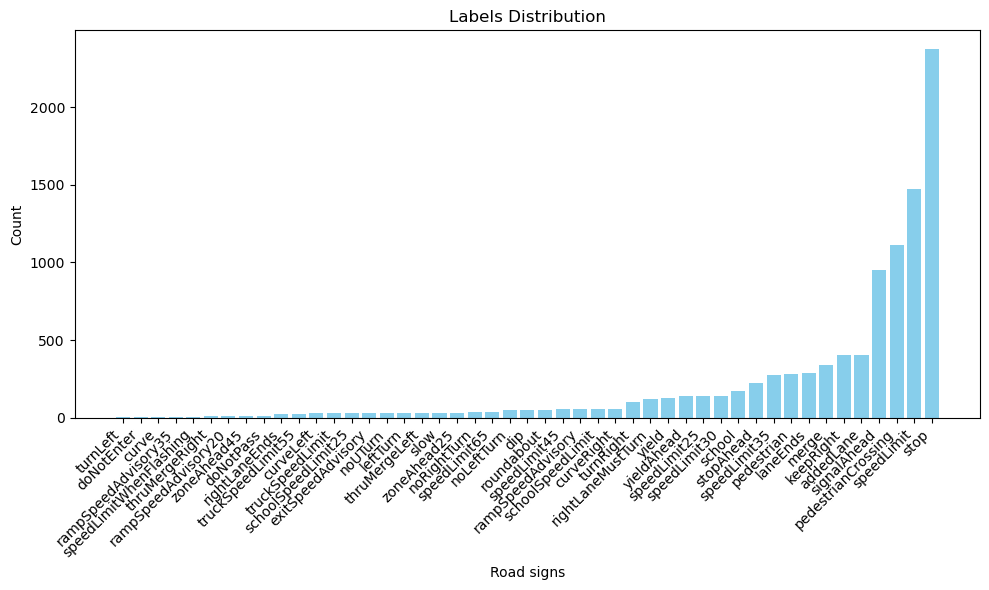

In [7]:
def plot_label_distribution(label_dict):
    labels = list(label_dict.keys())
    counts = list(label_dict.values())

    plt.figure(figsize=(10,6))
    plt.bar(labels, counts, color='skyblue')
    plt.title('Labels Distribution')
    plt.xlabel('Road signs')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_label_distribution(label_dict)



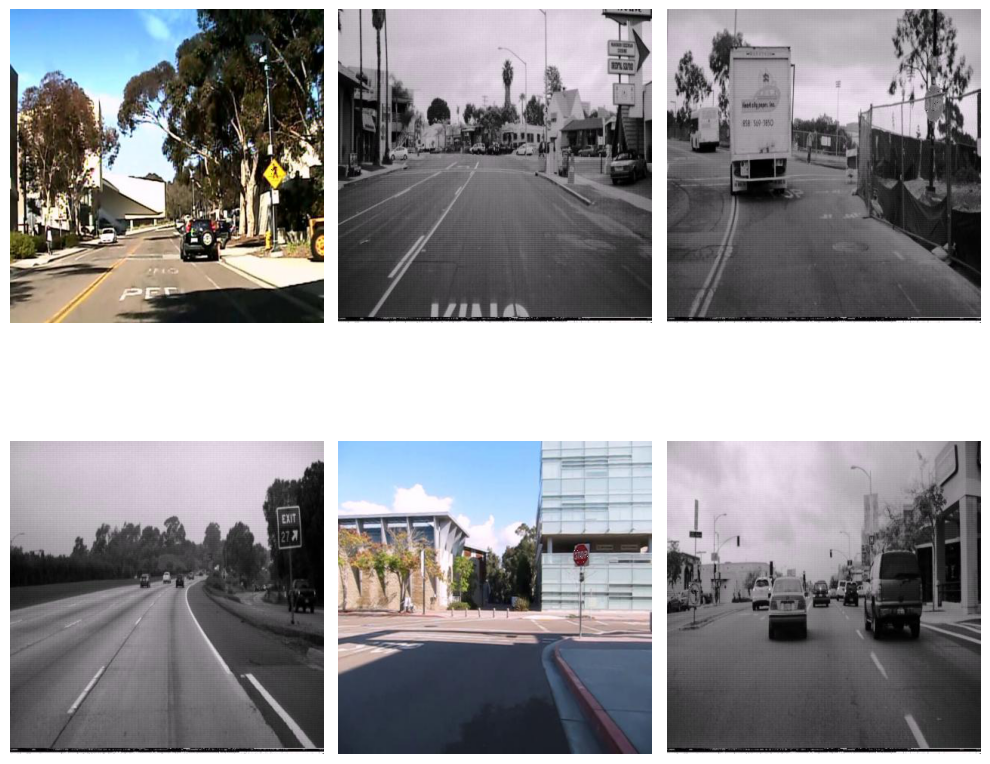

In [8]:
f, ax = plt.subplots(2, 3, figsize=(10, 10))
for idx, img_file in enumerate(os.listdir(TRAIN_PATH)[:6]):  # Limit to 6 images
    img_path = os.path.join(TRAIN_PATH, img_file)
    img = imread(img_path)
    row, col = divmod(idx, 3)  # Determine row and column
    ax[row, col].imshow(img)
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

In [9]:
filenames = sorted([f for f in os.listdir(TRAIN_PATH)])
labelnames = sorted([f for f in os.listdir(TRAIN_LABELS)])

# ensure both the list match in length
assert len(filenames) == len(labelnames)

data=[]
for file, label in zip(filenames, labelnames):
    image_path = os.path.join(TRAIN_PATH, file)
    label_path = os.path.join(TRAIN_LABELS, label)

    with open(label_path, 'r') as f:
        for line in  f:
            parts = line.strip().split()
            label = label.split('_')[0]
            x_center, y_center, width, height = map(float, parts[1:])

            # Append to dataset
            data.append({
                'filename' : file,
                'label' : label,
                'x_center' : x_center,
                'y_center' : y_center,
                'width' : width,
                'height' : height
            })

df = pd.DataFrame(data)

df.head()


    


,filename,label,x_center,y_center,width,height
0,addedLane_1323813414-avi_image0_png.rf.3aeab74...,addedLane,0.365385,0.461538,0.057091,0.081731
1,addedLane_1323813414-avi_image0_png.rf.8e156cc...,addedLane,0.365385,0.461538,0.057091,0.081731
2,addedLane_1323813414-avi_image2_png.rf.d5d0fae...,addedLane,0.292067,0.415865,0.079327,0.114784
3,addedLane_1323813414-avi_image2_png.rf.db67207...,addedLane,0.292067,0.415865,0.079327,0.114784
4,addedLane_1323813414-avi_image3_png.rf.4c7a5ed...,addedLane,0.234375,0.383413,0.091346,0.132812


0.5264423076923077 0.3918269230769231 0.019230769230769232 0.04807692307692308
0.5264423076923077 0.3918269230769231 8 20
215 153 223 173


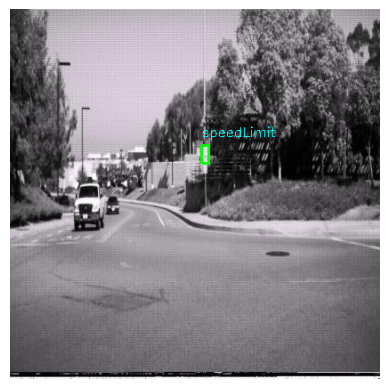

True

In [21]:
index = random.randint(0,11781)
x_center, y_center, width, height = df['x_center'][index], df['y_center'][index], df['width'][index], df['height'][index]
print(x_center, y_center, width, height)

file = os.path.join(TRAIN_PATH, df['filename'][index]) 
label = df['filename'][index].split('_')[0]
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# convert normalized co-ordinates to pixel values
x_c = int(x_center * w)
y_c = int(y_center * h)
box_width = int(width * w)
box_height = int(height * h)

print(x_center, y_center, box_width, box_height)

# calcualte the top left and bottm left corners
x1 = int(x_c - box_width / 2)
y1 = int(y_c - box_height / 2)
x2 = int(x_c + box_width / 2)
y2 = int(y_c + box_height / 2)

print(x1,y1,x2,y2)

# draw the bounding box
cv2.rectangle(image, (x1, y1), (x2, y2), color=(0,255,0), thickness = 2)

# add label text
cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)


# display the image wiht bounding box

plt.imshow(image)
plt.axis('off')
plt.show()
#cv2.imshow("Image with boudning box", image)
#cv2.waitKey()
#cv2.destroyAllWindows()

#save the image
cv2.imwrite("output_image.jpg", image)

In [22]:
os.getcwd()

'/Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project'

In [44]:
# Define the HOME directory
HOME = os.path.join(os.getcwd(), 'yolo')
print("HOME directory:", HOME)


# Install the YOLOv11 repository
!pip install -q git+https://github.com/THU-MIG/yolov10.git


HOME directory: /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/yolo


In [41]:
# Create the weights directory
!mkdir -p HOME/weights

# Download pretrained weights using curl
!curl -L -o HOME/weights/yolov10n.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!curl -L -o HOME/weights/yolov10s.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!curl -L -o HOME/weights/yolov10m.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!curl -L -o HOME/weights/yolov10b.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!curl -L -o HOME/weights/yolov10x.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!curl -L -o HOME/weights/yolov10l.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt

# List the files in the weights directory
!ls -lh HOME/weights


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.9M  100 10.9M    0     0  16.9M      0 --:--:-- --:--:-- --:--:-- 16.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 31.4M  100 31.4M    0     0  33.9M      0 --:--:-- --:--:-- --:--:-- 33.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63.8M  100 63.8M    0     0  46.5M      0  0:00:01  0:00:01 --:--:-- 73.6M
  % Total    % Received % Xferd  Average Speed   Tim

In [50]:
# load the model
model = YOLO('HOME/weights/yolov10n.pt')

results = model(os.path.join(TEST_PATH, 'addedLane_1323816833-avi_image1_png.rf.a9a81c177d70062b24eba511861c341a.JPG'))


image 1/1 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/LISA road signs.v1i.yolov11/test/images/addedLane_1323816833-avi_image1_png.rf.a9a81c177d70062b24eba511861c341a.JPG: 640x640 1 car, 1 truck, 50.3ms
Speed: 2.7ms preprocess, 50.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu"